In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import glob as gb
import seaborn as sns
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


2023-04-16 14:16:32.925939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMG_SIZE = 128
SEED = 1000
BATCH_SIZE = 32

TRAIN_DIR = '/Users/nagib/Desktop/tu/cvpr/Alzheimers-ADNI/train'
TEST_DIR = '/Users/nagib/Desktop/tu/cvpr/Alzheimers-ADNI/test'

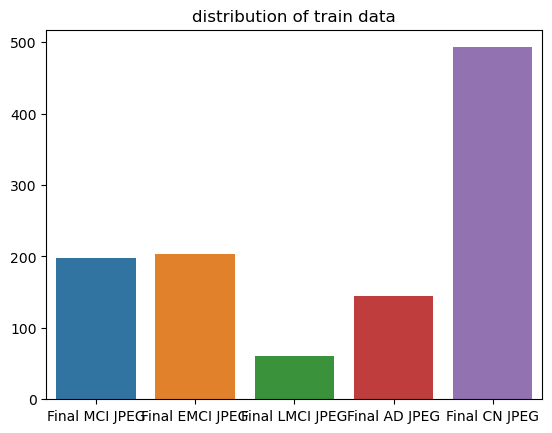

1101


In [3]:
categories = []
class_count = []
train_exm = 0
for f in os.listdir(TRAIN_DIR):
    files = gb.glob(pathname=str(TRAIN_DIR  + '//' + f + '/*.jpg'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")

plt.show()
print(train_exm)

In [4]:
train_gen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2,
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    # dtype = tf.float32
)

test_gen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    # dtype = tf.float32
)

In [5]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'training',
    seed = SEED
)
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'validation',
    seed = SEED
)
test_batch = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 883 images belonging to 5 classes.
Found 218 images belonging to 5 classes.
Found 195 images belonging to 5 classes.


In [6]:
img_shape = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False,  weights='imagenet')
base_model.summary()

2023-04-16 14:16:39.640366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [7]:
inputs = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [8]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [9]:
h = model.fit(
    train_batch,
    steps_per_epoch = 642 // BATCH_SIZE,
    validation_data=valid_batch,
    validation_steps=158 // BATCH_SIZE,
    epochs=10,
)

Epoch 1/10
20/20 [==============================] - 220s 11s/step - loss: 4.1000 - accuracy: 0.3562 - val_loss: 1.4380 - val_accuracy: 0.4766
Epoch 2/10
20/20 [==============================] - 207s 10s/step - loss: 1.6428 - accuracy: 0.4437 - val_loss: 1.3941 - val_accuracy: 0.4375
Epoch 3/10
20/20 [==============================] - 204s 10s/step - loss: 1.4863 - accuracy: 0.4242 - val_loss: 1.4158 - val_accuracy: 0.4766
Epoch 4/10
20/20 [==============================] - 204s 10s/step - loss: 1.4314 - accuracy: 0.4354 - val_loss: 1.4420 - val_accuracy: 0.4219
Epoch 5/10
20/20 [==============================] - 226s 11s/step - loss: 1.4453 - accuracy: 0.4466 - val_loss: 1.3926 - val_accuracy: 0.4688
Epoch 6/10
20/20 [==============================] - 230s 12s/step - loss: 1.4306 - accuracy: 0.4514 - val_loss: 1.4389 - val_accuracy: 0.4219
Epoch 7/10
20/20 [==============================] - 238s 12s/step - loss: 1.4382 - accuracy: 0.4418 - val_loss: 1.3938 - val_accuracy: 0.4766
Epoch 

In [10]:
inputs = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)

without_freezing_model = tf.keras.Model(inputs, output)
without_freezing_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                           

In [11]:
without_freezing_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [12]:
h1 = without_freezing_model.fit(
    train_batch,
    steps_per_epoch = 642 // BATCH_SIZE,
    validation_data=valid_batch,
    validation_steps=158 // BATCH_SIZE,  
    epochs=10,
)

Epoch 1/10
20/20 [==============================] - 402s 18s/step - loss: 1.5158 - accuracy: 0.4274 - val_loss: 1.4428 - val_accuracy: 0.4375
Epoch 2/10
20/20 [==============================] - 241s 12s/step - loss: 1.4527 - accuracy: 0.4386 - val_loss: 1.4188 - val_accuracy: 0.4531
Epoch 3/10
20/20 [==============================] - 243s 12s/step - loss: 1.4490 - accuracy: 0.4484 - val_loss: 1.4531 - val_accuracy: 0.3906
Epoch 4/10
20/20 [==============================] - 243s 12s/step - loss: 1.4364 - accuracy: 0.4434 - val_loss: 1.4047 - val_accuracy: 0.4453
Epoch 5/10
20/20 [==============================] - 249s 12s/step - loss: 1.4407 - accuracy: 0.4434 - val_loss: 1.4266 - val_accuracy: 0.4375
Epoch 6/10
20/20 [==============================] - 254s 13s/step - loss: 1.4116 - accuracy: 0.4721 - val_loss: 1.4459 - val_accuracy: 0.4219
Epoch 7/10
20/20 [==============================] - 250s 13s/step - loss: 1.4053 - accuracy: 0.4561 - val_loss: 1.3971 - val_accuracy: 0.4609
Epoch 

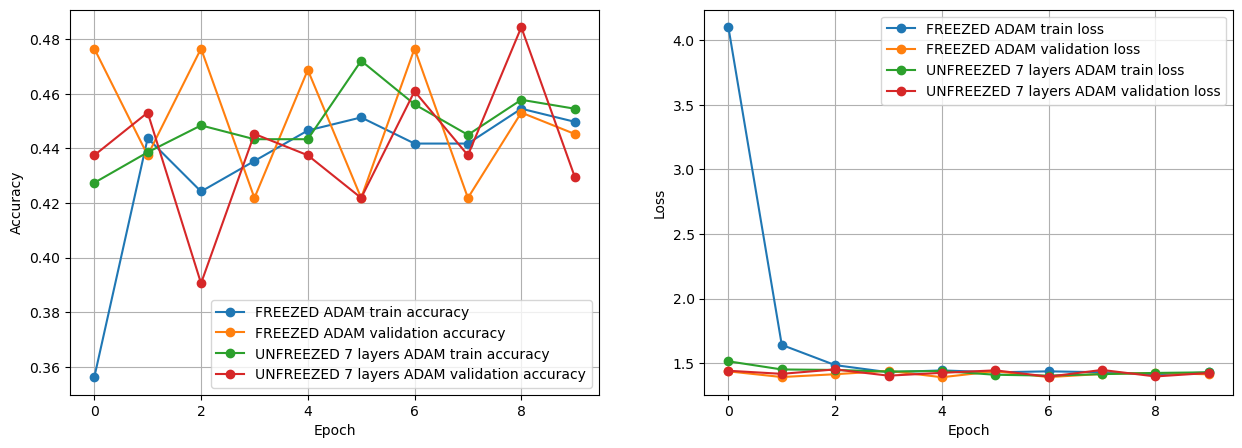

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='FREEZED ADAM train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'FREEZED ADAM validation accuracy')

plt.plot(h1.history['accuracy'], 'o-', label='UNFREEZED 7 layers ADAM train accuracy')
plt.plot(h1.history['val_accuracy'], 'o-', label = 'UNFREEZED 7 layers ADAM validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='FREEZED ADAM train loss')
plt.plot(h.history['val_loss'], 'o-', label='FREEZED ADAM validation loss')

plt.plot(h1.history['loss'], 'o-', label='UNFREEZED 7 layers ADAM train loss')
plt.plot(h1.history['val_loss'], 'o-', label='UNFREEZED 7 layers ADAM validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()